In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from preprocesor import PreprocessLagMatrix, PreprocessRemoveFirstElements
import numpy as np
import warnings
warnings.filterwarnings('ignore')

lag = 10

df = pd.read_excel('Consumo_energetico.xlsx')
maxval = df.consumo.max()
# df['consumo'] = df.consumo / maxval
df['consumo'] = scale(df['consumo'])
x, y = PreprocessLagMatrix(lag).execute(df.consumo)
x, y = PreprocessRemoveFirstElements(lag).execute(x, y)
x.head(10)

,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
10,-1.235489,-1.661684,-1.217535,-1.472214,-1.630606,-1.344747,-1.483003,-0.867334,-0.792468,-0.121912
11,-0.869799,-1.235489,-1.661684,-1.217535,-1.472214,-1.630606,-1.344747,-1.483003,-0.867334,-0.792468
12,-0.479260,-0.869799,-1.235489,-1.661684,-1.217535,-1.472214,-1.630606,-1.344747,-1.483003,-0.867334
13,-0.461204,-0.479260,-0.869799,-1.235489,-1.661684,-1.217535,-1.472214,-1.630606,-1.344747,-1.483003
14,-1.087392,-0.461204,-0.479260,-0.869799,-1.235489,-1.661684,-1.217535,-1.472214,-1.630606,-1.344747
15,-1.026965,-1.087392,-0.461204,-0.479260,-0.869799,-1.235489,-1.661684,-1.217535,-1.472214,-1.630606
16,-1.568571,-1.026965,-1.087392,-0.461204,-0.479260,-0.869799,-1.235489,-1.661684,-1.217535,-1.472214
17,-1.564961,-1.568571,-1.026965,-1.087392,-0.461204,-0.479260,-0.869799,-1.235489,-1.661684,-1.217535
18,-1.801086,-1.564961,-1.568571,-1.026965,-1.087392,-0.461204,-0.479260,-0.869799,-1.235489,-1.661684
19,-1.436603,-1.801086,-1.564961,-1.568571,-1.026965,-1.087392,-0.461204,-0.479260,-0.869799,-1.235489


In [2]:
y.head()

10   -0.869799
11   -0.479260
12   -0.461204
13   -1.087392
14   -1.026965
Name: consumo, dtype: float64

In [3]:
def eval_model(model, last_observation, times=1):
    y_pred_list = []
    x = last_observation
    def predict(model, val, list):
        y = model.predict(val.reshape([1,-1]))
        list.append(y)

    predict(model, x, y_pred_list)
    for i in range(times):
        # si el ultimo valor es 5; el vector x con valores [1,2,3,4] se convierte en [5,1,2,3]
        x = np.append(y_pred_list[-1], x[:-1])
        predict(model, x, y_pred_list)

    return np.array(y_pred_list)    

In [4]:

xtrain, xtest, ytrain, ytest = train_test_split(x, y, shuffle=False, test_size=0.1)

svm = SVR(gamma=1.2)
svm.fit(xtrain, ytrain)
score = svm.score(xtest, ytest)
ypred = svm.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print('score:{}\nmse:{}'.format(score,mse))

score:0.6311362447682156
mse:0.10862889264474437


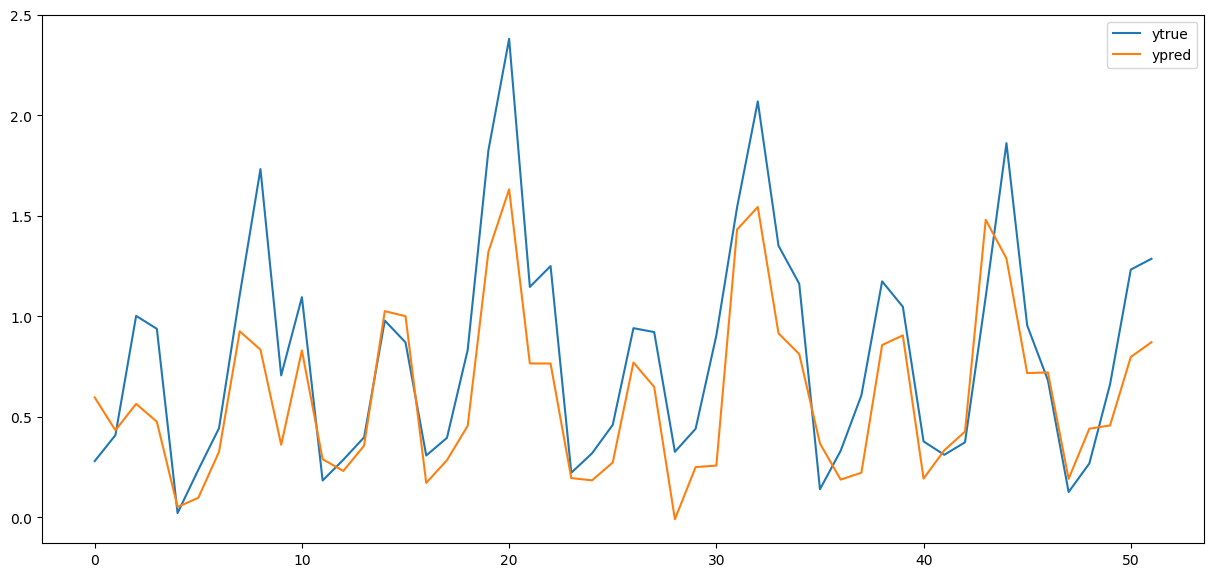

In [5]:
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

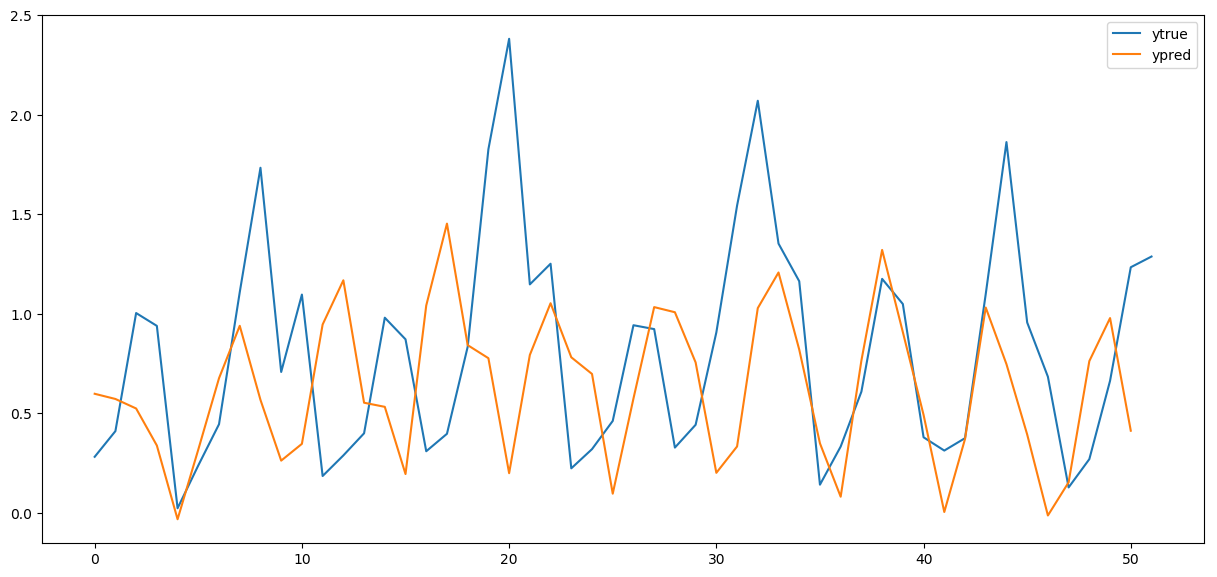

In [6]:
ypred = eval_model(svm, xtest.iloc[0], 50)
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import *

np.random.seed(7)
model = Sequential()
model.add(Dense(units=16, activation='tanh', input_dim=lag))
model.add(Dense(units=1, activation='linear'))
#opt = SGD(lr=0.01, momentum=0.2, decay=0.01)
opt = Adam(lr=0.01, decay=0.01)
model.compile(loss='mse',
              optimizer=opt)

model.fit(xtrain, ytrain, epochs=100, batch_size=64, verbose=0, shuffle=False);
ypred = model.predict(xtest)

Using CNTK backend


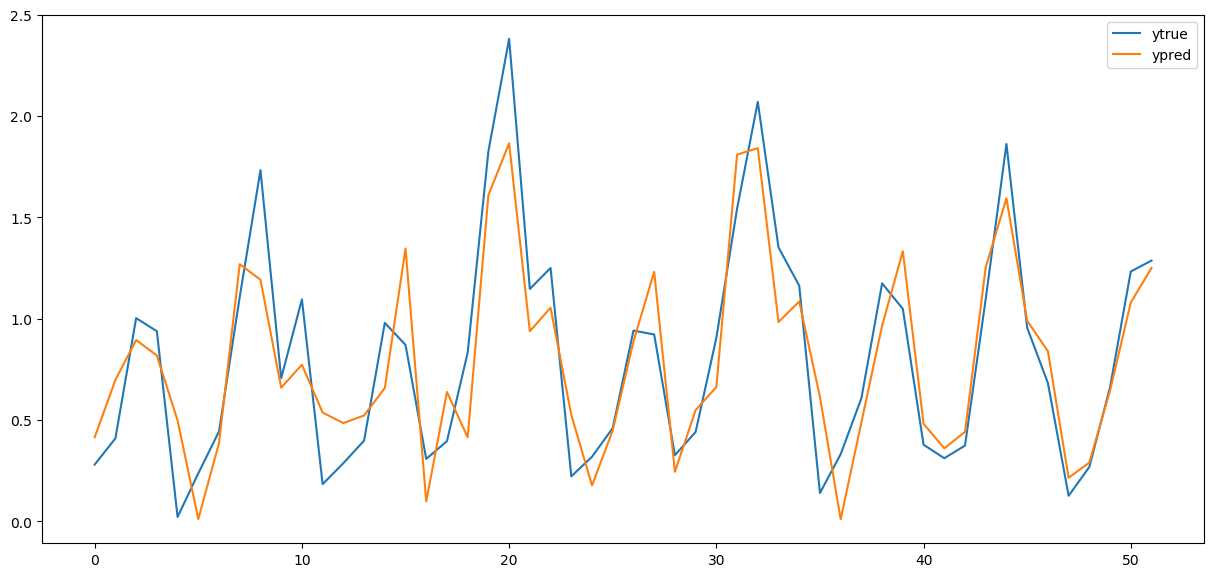

In [8]:
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [9]:
mse = mean_squared_error(ytest, ypred)
print(mse)

0.06164405507442786


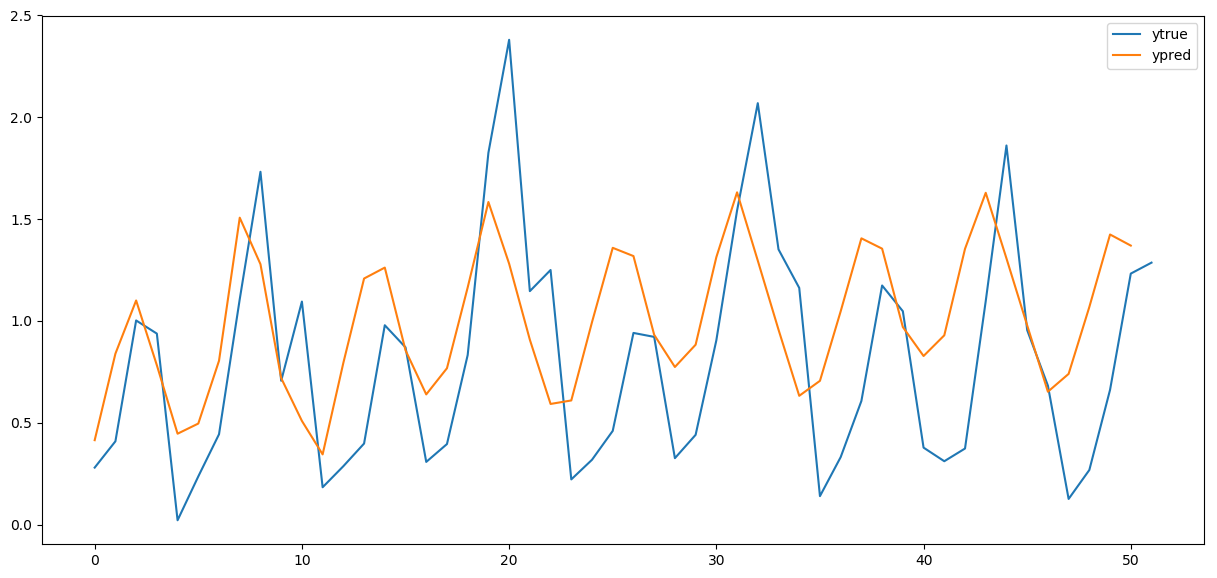

In [10]:
ypred=eval_model(model, xtest.iloc[0], 50).reshape([-1])
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [11]:
from sklearn.neural_network import MLPRegressor

np.random.seed(10)
regresor = MLPRegressor(hidden_layer_sizes=(10,10,8), activation='tanh', solver='lbfgs', shuffle=False, max_iter=100)
regresor.fit(xtrain, ytrain)
score = regresor.score(xtest, ytest)
ypred = regresor.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print('score:{}\nmse:{}'.format(score, mse))

score:0.8140374735675189
mse:0.054765216243828865


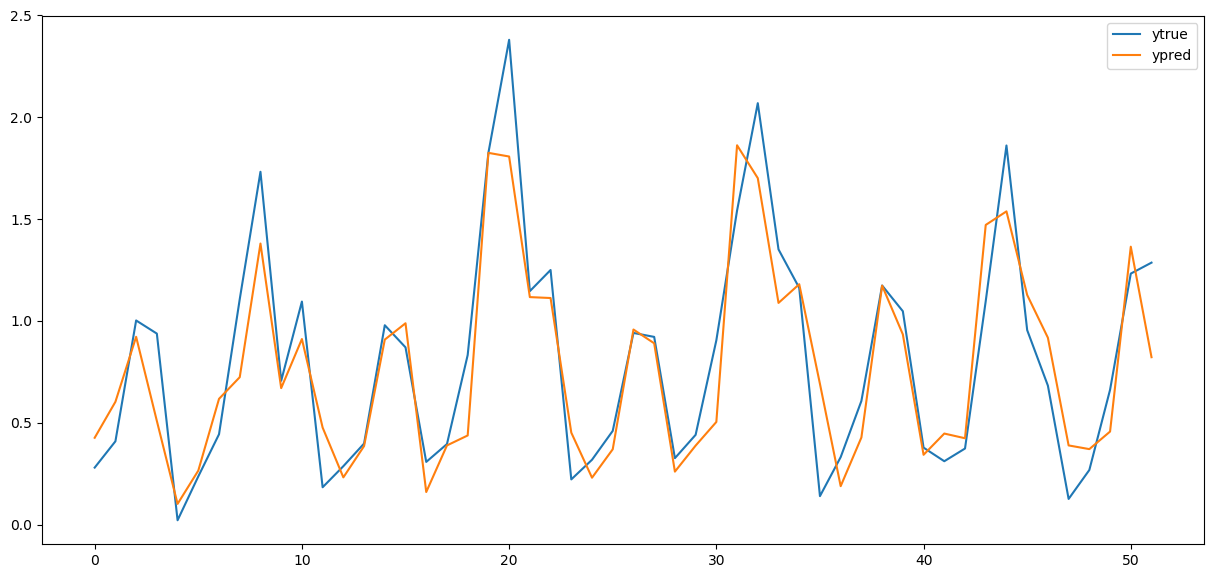

In [12]:
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

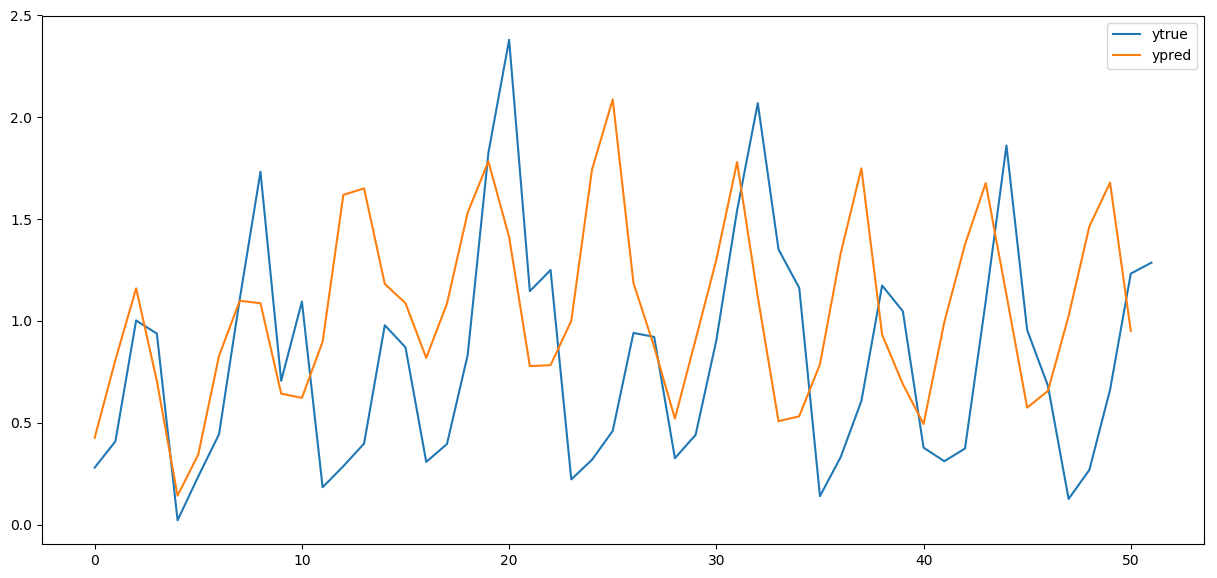

In [13]:
ypred=eval_model(regresor, xtest.iloc[0], 50).reshape([-1])
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [16]:
regresor.out_activation_

'identity'